<a href="https://colab.research.google.com/github/Rukaya-lab/NLP-notebooks/blob/main/First_nlp_ham_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve


In [ ]:
#import data set

from google.colab import files
upload = files.upload()

Saving spam.csv to spam.csv


In [ ]:
mail_data = pd.read_csv('spam.csv', encoding='latin-1')

mail_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
#drop the columns that arent needed and rename the text columns

mail_data = mail_data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

mail_data = mail_data.rename(columns={"v2" : "text", "v1":"label"})

mail_data.tail()

,label,text
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [ ]:
mail_data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
#download tokenizer
nltk.download("punkt")

#import warnings 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
ham_words = ''
spam_words = ''

# Creating a corpus of spam messages
for val in mail_data[mail_data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in mail_data[mail_data['label'] == 'ham'].text:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

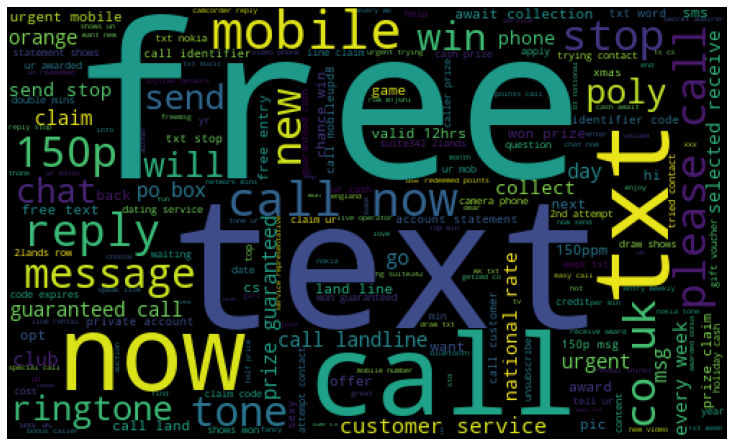

In [ ]:
from wordcloud import WordCloud

spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)


#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

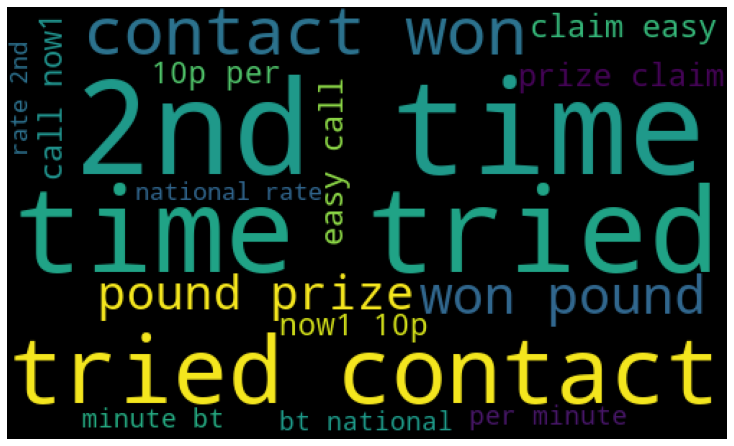

In [ ]:
#ham Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Preprocessing

Remove punctuation
Remove stop words

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#example stopwords
nltk.download('stopwords')
stopwords.words("english")[100:110]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']

In [ ]:
#remove punctuation and stop words

def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

mail_data['text'] = mail_data['text'].apply(text_process)
mail_data.head()

,label,text
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah dont think goes usf lives around though


In [ ]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(mail_data['text'])):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  11305


In [ ]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)

print(vocab[:100]) #return a list of the first 60 vocabulary words

['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'going', 'one', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ì', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell', 'take', 'much', 'night', 'way', 'Hey', 'reply', 'work', 'make', 'give', 'new', 'number', 'already', 'great', 'right', 'ask', 'Hi', 'say', 'tomorrow', '1', 'amp', 'well', 'claim', 'said', 'txt', 'Oh', 'Good', 'message', 'didnt', 'Txt', 'e', 'prize', 'meet', 'really', 'stop', 'ill', 'wat', 'Pls', 'msg', 'would', 'contact', '3', 'Please', 'find', 'morning', 'pick', 'every', 'sure', 'sent', 'STOP', 'miss']


In [ ]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [ ]:
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [ ]:
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape

(5572, 11305)

In [ ]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF = normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.



vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(mail_data['text'])
vectors.shape

(5572, 9376)

In [ ]:
#features = word_vectors
features = vectors

In [ ]:
#Vectorization counting the occurrences of tokens in each document.

bow_transformer = CountVectorizer(analyzer = text_process).fit(mail_data['text'])

print(len(bow_transformer.vocabulary_))


87


In [ ]:
sample_spam = mail_data['text'][8]
bow_sample_spam = bow_transformer.transform([sample_spam])
print(sample_spam)
print(bow_sample_spam)

WINNER valued network customer selected receivea å£900 prize reward claim call 09061701461 Claim code KL341 Valid 12 hours
  (0, 0)	17
  (0, 1)	5
  (0, 2)	5
  (0, 3)	1
  (0, 4)	1
  (0, 5)	2
  (0, 7)	2
  (0, 8)	1
  (0, 10)	2
  (0, 13)	1
  (0, 15)	1
  (0, 19)	1
  (0, 21)	1
  (0, 22)	1
  (0, 24)	2
  (0, 28)	1
  (0, 32)	1
  (0, 33)	1
  (0, 37)	7
  (0, 39)	6
  (0, 40)	5
  (0, 41)	12
  (0, 44)	1
  (0, 45)	5
  (0, 47)	1
  (0, 48)	7
  (0, 49)	3
  (0, 50)	1
  (0, 51)	4
  (0, 52)	1
  (0, 54)	7
  (0, 55)	3
  (0, 56)	3
  (0, 57)	3
  (0, 58)	2
  (0, 59)	2
  (0, 62)	1
  (0, 66)	1
  (0, 84)	1


In [ ]:
sample_ham = mail_data['text'][4]
bow_sample_ham = bow_transformer.transform([sample_ham])
print(sample_ham)
print(bow_sample_ham)

Nah dont think goes usf lives around though
  (0, 0)	7
  (0, 24)	1
  (0, 37)	2
  (0, 40)	2
  (0, 41)	2
  (0, 42)	1
  (0, 43)	2
  (0, 44)	4
  (0, 45)	2
  (0, 47)	1
  (0, 48)	1
  (0, 50)	3
  (0, 51)	4
  (0, 54)	1
  (0, 55)	3
  (0, 56)	3
  (0, 57)	3
  (0, 58)	1


In [ ]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, mail_data['label'], test_size=0.15, random_state=1111)

In [ ]:
#initializing different classifiers and comparing effectiveness

#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [ ]:
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [ ]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [ ]:
pred_scores_word_vectors

[('SVC', [0.9808612440191388]),
 ('KN', [0.9354066985645934]),
 ('NB', [0.9820574162679426]),
 ('DT', [0.9629186602870813]),
 ('LR', [0.9617224880382775]),
 ('RF', [0.9832535885167464])]

## Model prediction

In [ ]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [ ]:
newtext = ["I still dont understand some important concept, need to study more"]
integers = vectorizer.transform(newtext)

In [ ]:
x = knc.predict(integers)
find(x)


Message is NOT Spam
